# ResNet-15
(https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/)

Diseño de la arquitectura ResNet utilizando Tensorflow y Keras API

El dataset utilizado por default es CIFAR-10. Este conjunto contiene 60k imágenes a color de tamaño 32x32 en 10 diferentes clases. 

First, we import the keras module and its APIs. These APIs help in building architecture of the ResNet model.

In [1]:
# importar las librerías
# importar el módulo Keras y sus APIs. Estas APIs ayudarán a construir la arquitectura del modelo ResNet
import keras
from keras.layers import GlobalMaxPool2D, Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
# from keras.datasets import cifar10
from PIL import Image as im
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras import layers, Sequential, losses, metrics
import matplotlib.pyplot as plt

print("  Done! :D")

  Done! :D


### Importar los datos de los jets

In [2]:

# Ruta a los datos y las clases
dataPath = '/home/saksevul/T-MCC/OpenData/'
# ruta al tipo de jets a considerar
jetsType = 'Jets'
# directorio donde se ubican los archivos txt
txtFiles = jetsType+'/txtFiles/'

# Lista de los AODs dentro de path
aod = ['Jet', 'MultiJet']

# Ordensmos alfabéticamente
aod.sort()

# Lista de archivos con datos
eFile = []
hFile = []

# tamaño de las imagenes
eN = 34
eM = 72
hN = 34
hM = 72
lN = 34
lM = 72

# Encuentra los archivos de datos contenidos en los directorios
for i in os.listdir(dataPath+aod[0]+'_20000/'+txtFiles):
    if i[:5]=='ECal'+'-' and i[-4:]=='.txt':
        eFile.append(i[5:9])
    if i[:5]=='HCal'+'-' and i[-4:]=='.txt':
        hFile.append(i[5:9])

# reordenar los valores
eFile.sort()
hFile.sort()

print("eFile: ",eFile)
print("hFile: ",hFile)


# Extraer los datos necesarios

# semilla para los números aleatorios
np.random.seed(100)

# Porción de datos de entrenamiento
p = 0.5

# Definimos el conjunto de datos para el ECal, así como sus clases
for i in range(len(aod)):
    print(aod[i])
    for j in range(len(eFile)):
        if i==0 and j==0:
            eData = np.loadtxt(dataPath+aod[i]+'_20000/'+txtFiles+'ECal'+'-'+eFile[j]+'.txt')
            hData = np.loadtxt(dataPath+aod[i]+'_20000/'+txtFiles+'HCal'+'-'+hFile[j]+'.txt')
            jet = np.loadtxt(dataPath+aod[i]+'_20000/'+txtFiles+'Jet'+'-'+hFile[j]+'.txt', usecols=(0,1,2,3,4,5,6,7,8,9,10,11))
            rows = eData.shape[i]
            classes = np.ones(rows)*i
            # Indices del conjunto de entrenamiento y prueba del primer conjunto de AODs
            trainInd = np.random.choice(np.array(range(len(eFile)*rows)),int(p*len(eFile)*rows),replace=False)
            testInd = np.setdiff1d(np.array(range(len(eFile)*rows)),trainInd)
        else:
            eData = eval('np.concatenate((eData,np.loadtxt('+"'"+dataPath+aod[i]+'_20000/'+txtFiles+'ECal'+'-'+eFile[j]+'.txt'+"'"+')), axis=0)')
            hData = eval('np.concatenate((hData,np.loadtxt('+"'"+dataPath+aod[i]+'_20000/'+txtFiles+'HCal'+'-'+hFile[j]+'.txt'+"'"+')), axis=0)')
            jet = eval('np.concatenate((jet,np.loadtxt('+"'"+dataPath+aod[i]+'_20000/'+txtFiles+'Jet'+'-'+hFile[j]+'.txt'+"', usecols=(0,1,2,3,4,5,6,7,8,9,10,11)"+')), axis=0)')
            classes = eval('np.concatenate((classes,np.ones(rows)*i), axis=0)')
    if i>0:
        trainInd = np.concatenate((trainInd, i*len(eFile)*rows+trainInd[:int(p*len(eFile)*rows)]), axis=0)
        testInd = np.concatenate((testInd, i*len(eFile)*rows+testInd[:int(((10-10*p)/10)*len(eFile)*rows)]), axis=0)


# Mexclar una última vez los índices
trainInd = np.random.choice(trainInd,trainInd.shape[0],replace=False)
testInd = np.random.choice(testInd,testInd.shape[0],replace=False)

print("eData ", eData.shape, type(eData))
print("hData ", hData.shape, type(hData))
print("jet ", jet.shape, type(jet))
print("classes ", classes.shape, type(classes))

# Normalizar los datos y convertirlos en formato uint8 para convertirlos a imágenes PNG
lData = np.log(eData+hData+1)

# reescalamos todos los valores para ser re escritos en imágenes.
for i in range(eData.shape[0]):
    eMax = np.max(eData[i])
    hMax = np.max(hData[i])
    lMax = np.max(lData[i])
    eData[i] = eData[i]/eMax
    hData[i] = hData[i]/hMax
    lData[i] = lData[i]/lMax

# cambiar el formato de los datos
eData = eData.astype('float32')
hData = hData.astype('float32')
lData = lData.astype('float32')

eFile:  ['0006', '0007', '0008', '0012', '0014', '0017', '0020', '0021', '0024', '0034', '0035', '0039', '0040', '0042', '0044', '0045', '0060', '0064', '0066', '0067', '0070', '0072', '0081', '0083', '0084', '0085', '0090', '0093', '0094', '0101', '0107', '0109', '0112', '0116', '0117', '0120', '0122', '0123', '0124', '0127', '0129', '0135', '0136', '0139', '0145', '0147', '0152', '0154', '0157', '0158']
hFile:  ['0006', '0007', '0008', '0012', '0014', '0017', '0020', '0021', '0024', '0034', '0035', '0039', '0040', '0042', '0044', '0045', '0060', '0064', '0066', '0067', '0070', '0072', '0081', '0083', '0084', '0085', '0090', '0093', '0094', '0101', '0107', '0109', '0112', '0116', '0117', '0120', '0122', '0123', '0124', '0127', '0129', '0135', '0136', '0139', '0145', '0147', '0152', '0154', '0157', '0158']
Jet
MultiJet
eData  (6400, 2448) <class 'numpy.ndarray'>
hData  (6400, 2448) <class 'numpy.ndarray'>
jet  (6400, 12) <class 'numpy.ndarray'>
classes  (6400,) <class 'numpy.ndarray'>


### cambiar la forma de los datos para que sean como imágenes

In [3]:
# Crear las imágenes una a una
# Rescale Factor
rF = 1

x_train = np.ones((trainInd.shape[0],rF*lN,rF*lM,3), 'float32')
y_train = classes[trainInd].reshape(trainInd.shape[0],1)
x_test = np.ones((testInd.shape[0],rF*lN,rF*lM,3), 'float32')
y_test = classes[testInd].reshape(testInd.shape[0],1)

# ciclo sobre todos los datos de entrenamiento
for i in range(trainInd.shape[0]):
    # imprimir la información de la imagen a generar
    if ((i+1)%(trainInd.shape[0]/4)==0):
        print(" train: ",str(i+1)," / ",trainInd.shape[0])
    # Reescalar los arreglos a partir de los cuales se generarán las imágines))
    eDat = eData[trainInd[i]].reshape(eN,eM)
    hDat = hData[trainInd[i]].reshape(hN,hM)
    lDat = lData[trainInd[i]].reshape(lN,lM)
    for j in range(rF*eN):
        for k in range(rF*eM):
            x_train[i][j][k][0] = x_train[i][j][k][0]*eDat[int(j/rF)][int(k/rF)]
            x_train[i][j][k][1] = x_train[i][j][k][1]*hDat[int(j/rF)][int(k/rF)]
            x_train[i][j][k][2] = x_train[i][j][k][2]*lDat[int(j/rF)][int(k/rF)]
    #eD = np.kron(eData[trainInd[i]].reshape(eN,eM), np.ones((rF,rF), dtype=np.int8))
    
    
# ciclo sobre todos los datos de prueba
for i in range(testInd.shape[0]):
    # imprimir la información de la imagen a generar
    if ((i+1)%(testInd.shape[0]/4)==0):
        print("  test: ",str(i+1)," / ",testInd.shape[0])
    # Reescalar los arreglos a partir de los cuales se generarán las imágines))
    eDat = eData[testInd[i]].reshape(eN,eM)
    hDat = hData[testInd[i]].reshape(hN,hM)
    lDat = lData[testInd[i]].reshape(lN,lM)
    for j in range(rF*eN):
        for k in range(rF*eM):
            x_test[i][j][k][0] = x_test[i][j][k][0]*eDat[int(j/rF)][int(k/rF)]
            x_test[i][j][k][1] = x_test[i][j][k][1]*hDat[int(j/rF)][int(k/rF)]
            x_test[i][j][k][2] = x_test[i][j][k][2]*lDat[int(j/rF)][int(k/rF)]


# Print Training and Test Samples
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

 train:  800  /  3200
 train:  1600  /  3200
 train:  2400  /  3200
 train:  3200  /  3200
  test:  800  /  3200
  test:  1600  /  3200
  test:  2400  /  3200
  test:  3200  /  3200
x_train shape: (3200, 34, 72, 3)
x_test shape: (3200, 34, 72, 3)
3200 train samples
3200 test samples
y_train shape: (3200, 1)
y_test shape: (3200, 1)


Now, We set different hyper parameters that is required for ResNet architecture. We also done some preprocess our datasets to prepare it for training.

In [4]:
# definimos diferentes hiperparámetros que son necesarios para la arquitectura de la ResNet.
# realizamos preprocesamiento a las imágenes para el entrenamiento

# Setting Training Hyperparameters
batch_size = 32 # original ResNet paper uses batch_size = 128 for training
epochs = 128
data_augmentation = True
# número de clases
num_classes = 2

# Data Preprocessing
subtract_pixel_mean = True

# núemero de capas convolucionales
n = 3

# Computed depth of
depth = n * 6 + 2

# Model name and depth
model_type = 'ResNet-%d' % (15)

In [5]:
# # Load the CIFAR-10 data.
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Print Training and Test Samples
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
# print('y_train shape:', y_train.shape)

# # Normalize data. 
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255


# Input image dimensions.
input_shape = x_train.shape[1:]

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis = 0)
    x_train -= x_train_mean
    x_test -= x_train_mean

# Convert class vectors to binary class matrices.
yTrain = y_train
y_train = keras.utils.to_categorical(y_train, num_classes)
yTest = y_test
y_test = keras.utils.to_categorical(y_test, num_classes)

print("  Done! :D")

  Done! :D


In this step, we set the learning rate according to the number of epochs. As the number of epochs the learning rate must be decreased to ensure better learning.

In [6]:
# Setting LR for different number of Epochs
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

print("  Done! :D")

  Done! :D


In this step we define basic ResNet building block that can be used for defining the ResNet V1 and V2 architecture.

In [7]:
# Basic ResNet Building Block
def resnet_layer(inputs,
                num_filters = 16,
                kernel_size = 3,
                strides = 1,
                activation ='relu',
                batch_normalization = True,
                conv_first = True):
    
    conv = Conv2D(num_filters,
                kernel_size = kernel_size,
                strides = strides,
                padding ='same',
                kernel_initializer ='he_normal',
                kernel_regularizer = l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

print("  Done! :D")

  Done! :D


Arquitectura de la ResNet-15 implementada en el estado del arte

In [8]:
# ResNet-34
def resnet_34(input_shape, depth, num_classes = num_classes):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    # n is the number of resnet blocks
    num_res_blocks = int((depth - 2) / 6)
    
    inputs = Input(shape = input_shape)
    
    # Conv2D, 7x7 16, /2
    #x = resnet_layer(inputs = inputs)
    x = resnet_layer(inputs=inputs, num_filters=num_filters, kernel_size=7, strides=2, activation=None)
    # MaxPool, /2
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0:
                num_filters = 32
            if stack == 1: # first layer but not first stack
                strides = 2 # downsample
            if stack == 1 and res_block > 0:
                continue
            # Residual block
            y = resnet_layer(inputs = x,
                            num_filters = num_filters,
                            strides = strides)
            y = resnet_layer(inputs = y,
                            num_filters = num_filters,
                            activation = None)
            # residual block's skip connection
            if stack > 0 and res_block == 0: # first layer but not first stack
                # linear projection residual shortcut connection to match changed dims
                x = resnet_layer(inputs = x,
                                num_filters = num_filters,
                                kernel_size = 1,
                                strides = strides,
                                activation = None,
                                batch_normalization = False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
    
    # GlobalMaxPool
    x = GlobalMaxPool2D()(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation ='softmax',
                    kernel_initializer ='he_normal')(y)
    
    # Instantiate model.
    model = Model(inputs = inputs, outputs = outputs)
    return model

print("  Done! :D")

  Done! :D


## Main function
The code below is used to train and test the ResNet v1 and v2 architecture we defined above:

In [9]:
# Main function
model = resnet_34(input_shape = input_shape, depth = depth)

model.compile(loss ='categorical_crossentropy',
            optimizer = Adam(learning_rate = lr_schedule(0)),
            metrics =[metrics.Precision(), metrics.Recall()])
model.summary()
print(model_type)

# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_% s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath = filepath,
                            monitor ='val_acc',
                            verbose = 1,
                            save_best_only = True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                            cooldown = 0,
                            patience = 5,
                            min_lr = 0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
            batch_size = batch_size,
            epochs = epochs,
            validation_data =(x_test, y_test),
            shuffle = True,
            callbacks = callbacks,
             verbose=1)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center = False,
        # set each sample mean to 0
        samplewise_center = False,
        # divide inputs by std of dataset
        featurewise_std_normalization = False,
        # divide each input by its std
        samplewise_std_normalization = False,
        # apply ZCA whitening
        zca_whitening = False,
        # epsilon for ZCA whitening
        zca_epsilon = 1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range = 0,
        # randomly shift images horizontally
        width_shift_range = 0.1,
        # randomly shift images vertically
        height_shift_range = 0.1,
        # set range for random shear
        shear_range = 0.,
        # set range for random zoom
        zoom_range = 0.,
        # set range for random channel shifts
        channel_shift_range = 0.,
        # set mode for filling points outside the input boundaries
        fill_mode ='nearest',
        # value used for fill_mode = "constant"
        cval = 0.,
        # randomly flip images
        horizontal_flip = True,
        # randomly flip images
        vertical_flip = False,
        # set rescaling factor (applied before any other transformation)
        rescale = None,
        # set function that will be applied on each input
        preprocessing_function = None,
        # image data format, either "channels_first" or "channels_last"
        data_format = None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split = 0.1)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                        validation_data =(x_test, y_test),
                        epochs = epochs, verbose = 1, workers = 4,
                        callbacks = callbacks)
    # Variable para extraer las métricas del entrenamiento
    history_dict = history.history
    history_dict.keys()

print("  Done! :D")

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34, 72, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 17, 36, 16)   2368        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 17, 36, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 18, 16)    0           batch_normalization[0][0]        
________________________________________________________________________

2022-03-09 19:48:37.267581: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-09 19:48:37.267716: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-09 19:48:37.268543: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/saksevul/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is 

Epoch 1/128
Learning rate:  0.001


2022-03-09 19:48:37.479731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-09 19:48:37.498918: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2496000000 Hz


100/100 [==============================] - 232s 2s/step - loss: 1.3302 - precision: 0.6146 - recall: 0.6146 - val_loss: 1.8055 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/128
Learning rate:  0.001
100/100 [==============================] - 229s 2s/step - loss: 0.7729 - precision: 0.7354 - recall: 0.7354 - val_loss: 2.1119 - val_precision: 0.5003 - val_recall: 0.5003
Epoch 3/128
Learning rate:  0.001
100/100 [==============================] - 231s 2s/step - loss: 0.6051 - precision: 0.7985 - recall: 0.7985 - val_loss: 2.1461 - val_precision: 0.5163 - val_recall: 0.5163
Epoch 4/128
Learning rate:  0.001
100/100 [==============================] - 232s 2s/step - loss: 0.4356 - precision: 0.8611 - recall: 0.8611 - val_loss: 0.6180 - val_precision: 0.7819 - val_recall: 0.7819
Epoch 5/128
Learning rate:  0.001
100/100 [==============================] - 230s 2s/step - loss: 0.3810 - precision: 0.8944 - recall: 0.8944 - val_loss: 0.3582 - val_precision: 0.8959 - val_recall: 0.8959
Epoc

Epoch 30/128
Learning rate:  0.001
100/100 [==============================] - 255s 3s/step - loss: 0.2521 - precision: 0.9380 - recall: 0.9380 - val_loss: 0.3135 - val_precision: 0.9153 - val_recall: 0.9153
Epoch 31/128
Learning rate:  0.001
100/100 [==============================] - 256s 3s/step - loss: 0.2176 - precision: 0.9501 - recall: 0.9501 - val_loss: 0.2856 - val_precision: 0.9275 - val_recall: 0.9275
Epoch 32/128
Learning rate:  0.001
100/100 [==============================] - 258s 3s/step - loss: 0.2255 - precision: 0.9455 - recall: 0.9455 - val_loss: 0.3891 - val_precision: 0.8856 - val_recall: 0.8856
Epoch 33/128
Learning rate:  0.001
100/100 [==============================] - 254s 3s/step - loss: 0.2468 - precision: 0.9378 - recall: 0.9378 - val_loss: 0.3011 - val_precision: 0.9178 - val_recall: 0.9178
Epoch 34/128
Learning rate:  0.001
100/100 [==============================] - 245s 2s/step - loss: 0.2324 - precision: 0.9398 - recall: 0.9398 - val_loss: 0.2714 - val_prec

Epoch 59/128
Learning rate:  0.001
100/100 [==============================] - 221s 2s/step - loss: 0.1851 - precision: 0.9557 - recall: 0.9557 - val_loss: 0.2396 - val_precision: 0.9438 - val_recall: 0.9438
Epoch 60/128
Learning rate:  0.001
100/100 [==============================] - 227s 2s/step - loss: 0.1983 - precision: 0.9481 - recall: 0.9481 - val_loss: 0.2656 - val_precision: 0.9237 - val_recall: 0.9237
Epoch 61/128
Learning rate:  0.001
100/100 [==============================] - 224s 2s/step - loss: 0.2173 - precision: 0.9408 - recall: 0.9408 - val_loss: 0.2335 - val_precision: 0.9397 - val_recall: 0.9397
Epoch 62/128
Learning rate:  0.001
100/100 [==============================] - 223s 2s/step - loss: 0.1805 - precision: 0.9539 - recall: 0.9539 - val_loss: 0.2619 - val_precision: 0.9291 - val_recall: 0.9291
Epoch 63/128
Learning rate:  0.001
100/100 [==============================] - 229s 2s/step - loss: 0.1773 - precision: 0.9551 - recall: 0.9551 - val_loss: 0.2176 - val_prec

Epoch 88/128
Learning rate:  0.0001
100/100 [==============================] - 224s 2s/step - loss: 0.1276 - precision: 0.9737 - recall: 0.9737 - val_loss: 0.1928 - val_precision: 0.9544 - val_recall: 0.9544
Epoch 89/128
Learning rate:  0.0001
100/100 [==============================] - 226s 2s/step - loss: 0.1274 - precision: 0.9746 - recall: 0.9746 - val_loss: 0.2005 - val_precision: 0.9506 - val_recall: 0.9506
Epoch 90/128
Learning rate:  0.0001
100/100 [==============================] - 223s 2s/step - loss: 0.1414 - precision: 0.9719 - recall: 0.9719 - val_loss: 0.1984 - val_precision: 0.9491 - val_recall: 0.9491
Epoch 91/128
Learning rate:  0.0001
100/100 [==============================] - 220s 2s/step - loss: 0.1379 - precision: 0.9641 - recall: 0.9641 - val_loss: 0.1881 - val_precision: 0.9547 - val_recall: 0.9547
Epoch 92/128
Learning rate:  0.0001
100/100 [==============================] - 222s 2s/step - loss: 0.1286 - precision: 0.9738 - recall: 0.9738 - val_loss: 0.2076 - val

100/100 [==============================] - 226s 2s/step - loss: 0.1362 - precision: 0.9723 - recall: 0.9723 - val_loss: 0.1913 - val_precision: 0.9556 - val_recall: 0.9556
Epoch 117/128
Learning rate:  0.0001
100/100 [==============================] - 224s 2s/step - loss: 0.1279 - precision: 0.9689 - recall: 0.9689 - val_loss: 0.1917 - val_precision: 0.9563 - val_recall: 0.9563
Epoch 118/128
Learning rate:  0.0001
100/100 [==============================] - 222s 2s/step - loss: 0.1210 - precision: 0.9751 - recall: 0.9751 - val_loss: 0.1898 - val_precision: 0.9566 - val_recall: 0.9566
Epoch 119/128
Learning rate:  0.0001
100/100 [==============================] - 226s 2s/step - loss: 0.1184 - precision: 0.9752 - recall: 0.9752 - val_loss: 0.1937 - val_precision: 0.9559 - val_recall: 0.9559
Epoch 120/128
Learning rate:  0.0001
100/100 [==============================] - 223s 2s/step - loss: 0.1222 - precision: 0.9730 - recall: 0.9730 - val_loss: 0.1897 - val_precision: 0.9578 - val_recall:

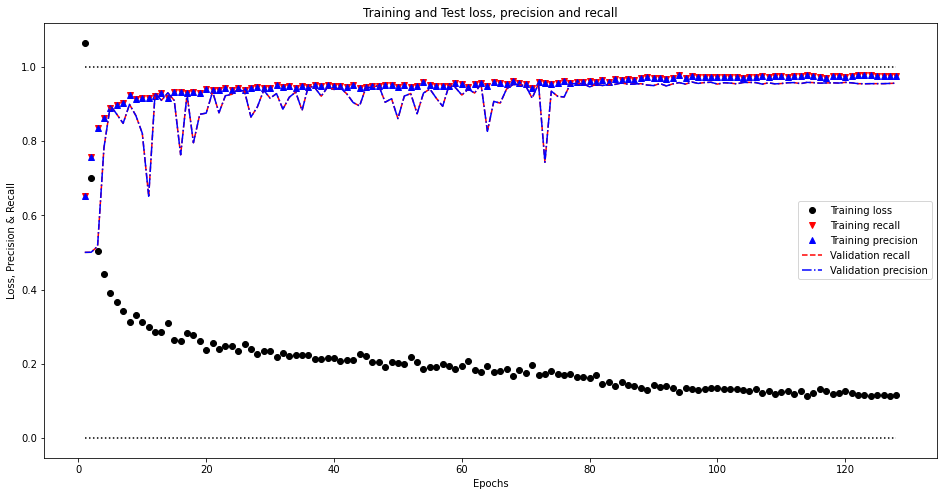

In [10]:
# Define variables
epochs = range(1, len(history_dict['loss'])+1)
y = np.ones((len(history_dict['loss'])))
z = np.ones((len(history_dict['loss'])))*0
plt.figure(figsize=(16,8))
plt.plot(epochs, y, 'k', linestyle=':')
plt.plot(epochs, z, 'k', linestyle=':')
# Grafica los valores obtenidos en cada
plt.plot(epochs, history_dict['loss'], 'ko', label='Training loss')
plt.plot(epochs, history_dict['recall'], 'rv', label='Training recall')
plt.plot(epochs, history_dict['precision'], 'b^', label='Training precision')
# plt.plot(epochs, history_dict['val_loss'], 'k', label='Validation loss')
plt.plot(epochs, history_dict['val_recall'], 'r', linestyle='--', label='Validation recall')
plt.plot(epochs, history_dict['val_precision'], 'b', linestyle='-.', label='Validation precision')
plt.title('Training and Test loss, precision and recall')
#plt.suptitle('Dense NN')
plt.xlabel('Epochs')
plt.ylabel('Loss, Precision & Recall')
plt.legend()
plt.show()


In [11]:
# model
print(model_type, ' wirh ', jetsType)
print('Epochs: ', epochs)
print('Batch size', batch_size)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose = 1)
print('Test loss:', scores[0])
print('Test precision:', scores[1])
print('Test recall:', scores[2])

# Predicciones del modelo
clasesPred = np.argmax(model.predict(x_test), axis = 1)
# matriz de confusión 
matrix = tf.math.confusion_matrix(yTest, np.round(clasesPred))
print(matrix)

ResNet-15  wirh  Jets
Epochs:  range(1, 129)
Batch size 32
100/100 [==============================] - 1s 6ms/step - loss: 0.1949 - precision: 0.9556 - recall: 0.9556
Test loss: 0.1948726326227188
Test precision: 0.9556249976158142
Test recall: 0.9556249976158142
tf.Tensor(
[[1546   54]
 [  88 1512]], shape=(2, 2), dtype=int32)
